In [33]:
# Install necessary Python modules for the code in this notebook.
# Uncomment following two lines if you have import failures:
# import sys
# !{sys.executable} -m pip install xxhash msgpack zstd cryptography

# Import modules needed for sample code below
import base64, io, typing, msgpack, zstd
from collections import namedtuple
from struct import pack, unpack
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
from xxhash import xxh64

Background
----------

Vail is a S3-compatible object storage system created by Spectra
Logic, featuring lifecycle policies that can store object data to
tape. The Vail Tape Format (VTF) specifies the format of these tapes,
so that others may create compatible systems or tools.

This specification overlays the Linear Tape File System (LTFS). An
implementation of the Vail Tape Format will want to refer to the [LTFS
specification][ltfs] or use a pre-built LTFS driver. LTFS provides a
format for storing files on tape with a POSIX programming interface.
The Vail Tape Format layers on top of a set of LTFS tapes to provide:

[ltfs]: https://www.snia.org/tech_activities/standards/curr_standards/ltfs

1. Efficient object and metadata packing. VTF uses large files on
   LTFS, which both minimizes the overhead of LTFS metadata and tape
   load/unload time.

2. Support for very small and very large object sizes. Very small
   objects will be packed into large LTFS files, allowing rapid
   transfer of many small objects to/from tape. Very large objects may
   span tapes.

3. S3-compliant object versioning. Unlike POSIX, objects in VTF may
   have multiple versions, including delete markers.

4. S3-compliant object names and metadata. POSIX and S3 have different
   naming restrictions and differences in the format of metadata. VTF
   captures object metadata in LTFS files, similar to object data.

5. Modern compression, encryption, and hash codes. VTF uses Zstandard
   compression, which allows users a great deal of flexibility to
   trade off speed vs. compression efficiency. AES-256 encryption is
   used, with flexible AES key identifiers that may reference Amazon
   Web Services KMS. Data integrity is assured with modern hash codes
   such as XXHash.

6. Support for tape-set parity. In configurations with multiple tape
   libraries, parity packs may be stored to maximize data availability
   in the event that a library is down or a set of tapes is damaged.

In addition to LTFS, a VTF implementation uses [MessagePack][msgpack]
to encode various VTF structures. MessagePack implementations are
available for most programming languages.

[msgpack]: https://msgpack.org/

Object System Concepts
----------------------

Vail, and other S3-compatible object stores, have different concepts
and terminology than file systems. This section provides an overview.

<img src="figures/concepts1.pdf" alt="Buckets, Objects, and Versions" />

<img src="figures/concepts1.png" width="50%" />

![Buckets, Objects, Versions](figures/concepts1.pdf)

![Buckets, Objects, Versions](figures/concepts1.png)

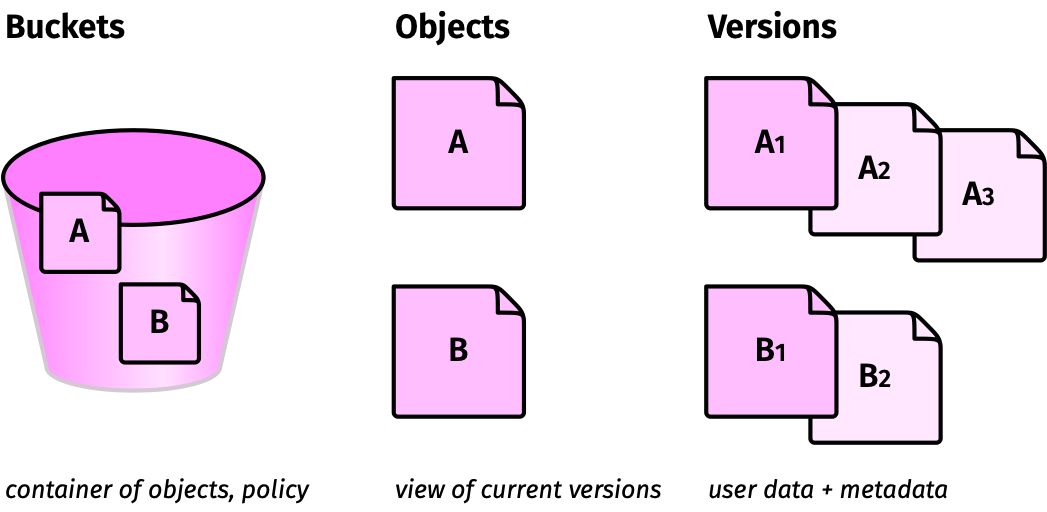

### Buckets

A *bucket* is the outermost container for objects; it is most similar
to a file system. Buckets tend to have high-level policies that apply
to all objects within them, for example lifecycle policies that
control where data is placed and when tape copies are mode.

### Objects and Versions

Buckets contain *objects*. Each object has a name (or key) and other
metadata associated with it, and a map of data blocks. Objects have
one or more *versions*. The last version for a given name is called
the *current version*. The object may be thought of as a pointer to
the current version. To avoid confusion, this document will almost
exclusively discuss versions instead of objects.

Vail stores its version records in a database separate from the
storage pools. When saving versions to tape, it also makes backups of
the version records so that the tape set will contain both the data
and metadata for all objects on tape.

<img src="figures/concepts2.pdf" alt="Blocks and Packs" />

### Blocks

A version's data is stored in one or more *blocks*. Each block is a
slice of object data, typically 10MB in size before compression. An
object whose length is less than the block length will simply be
composed of one short block. A larger object will be composed of
multiple blocks with a short block at the end. Each block is
compressed and encrypted individually so that a S3 client performing
range reads may be answered by decoding only the blocks containing the
range the client is asking for.

A set of blocks are stored together in *packs*. Packs are typically
large files, where the optimal pack size is determined by the type of
storage media. For tape, packs will be multiple gigabytes in size, and
will contain hundreds of blocks stored end-to-end. Packs may contain
blocks belonging to many versions.

Packs may also contain version records, not just blocks. These version
packs allow a tape set to be fully self-describing.


Tape Format Overview
--------------------

The Vail Tape Format is composed of several levels. At each level is
an encoding scheme that is straightforward to implement, while
providing high runtime efficiency. This section presents an overview
of each level, with detailed descriptions in following sections.

<img src="figures/levels.pdf" alt="Data Format Layering" />

### Level 0: LTFS

The base (zero) level in the system is LTFS, as specified by the LTFS
Format Specification version 2 or later. Any LTFS-compliant driver may
be used. The Vail Tape Format should be implemented in a user-space
process, using standard POSIX file system calls to manipulate the
files on a LTFS tape. LTFS uses a combination of data blocks, index
blocks, and file marks to lay out data on a tape. This is entirely
transparent to the Vail Tape Format, however.

### Level 1: Packs

The first level is *packs*, which are LTFS files that store encoded
data or metadata. Each pack stores either object data in the form of
*blocks*, or metadata in the form of *versions*. Both are described in
later sections.

LTFS may use one or more extents to store a file, and each extent is a
series of data blocks followed by an index block describing the
extent. LTFS also stores the index block in a separate index partition
which is read when a tape is mounted. Level one is also mostly
transparent to a VTF implementation.

### Level 2: TLV

The second level is an end-to-end stacking of records within packs.
Each record is encoded with a tag-length-value (TLV) format that uses a
fixed-size header and variable-length value. This header contains the
minimal information required to identify the type of data stored, its
length, and hash codes to validate both the header's integrity and the
value's integrity. Any TLV may be read and decoded by simply reading
its range of bytes within the pack. Pack files do not contain a header
or footer.

### Level 3: Value Encoding

The third level uses a variable-size header that provides details on
compression, encryption, and the application version used to encode
the value. MessagePack is used to decode the header first, then the
value contents must be decrypted and decompressed, then those
block/version bytes are decoded using MessagePack. MessagePack is a
fast and lightweight binary encoding format.

Pack Files
----------

Packs are named with a [ULID][ulid] followed by the extension `.blk`
for packs containing blocks, or `.ver` for packs containing versions.
Blocks and versions are stored separately so that a system importing a
set of tapes need only scan the `.ver` packs to build its database of
metadata.

[ulid]: https://github.com/oklog/ulid

ULID is similar to a UUID, however it contains an embedded timestamp
and sorts lexicographically from oldest time to newest time. Vail
creates a pack identifier using the current time (in UTC) when the
pack is first written to.

Pack files will be stored in the root directory of a LTFS tape.

It is important for read performance that pack files be stored as long
runs of contiguous LTFS data extents. While LTFS supports interleaving
of file data--which may happen if multiple files are written
concurrently--this is not very efficient, as reading such a file will
require LTFS to perform many seeks. Therefore it is strongly
recommended that a VTF writer sequentially write a full packs to tape,
one pack at a time, so that packs may be composed of large LTFS
extents without on-tape interleaving.

TLV Encoding
------------

<img src="figures/tlv_header.pdf" alt="TLV Header" />

The tag-length-value (TLV) format is used to pack many records into a
pack file. Its role is to provide just enough information for an
application to scan through a pack file, hop from one TLV to the next,
and ensure that records are valid before attempting to decode them.

TLV uses a 32 byte header and variable-length value. A TLV reader
should read the header and validate it using these steps, as illustrated in `read_tlv_header()` below:

1. The header "magic" is correct. The sequence should match
   `0x89`, `T`, `L`, `V`, `0x0d`, `0x0a`, `0x1a`, `0x0a`. This
   sequence identifies the TLV and allows early detection of certain
   types of corruption, for example end-of-line mangling if the TLV
   was accidentally treated as text. (The header magic is borrowed
   from the PNG file format. Further detail on its rationale may be
   found in the [PNG file format specification][png]).

2. The version at byte 24 indicates the version of the
   TLV format used when this TLV was created. This is currently 0. Decoding
   should stop if an unknown version number is seen.

3. At this point the header hash should be calculated and verified.
   The hash type is stored at byte 27, and header hash value is stored at bytes 30..31.
   Hash type 8, XXHash64, is standard. This is validated by
   calculating a [XXHash64][xxhash], keeping only the lower 16
   bits, and comparing those to the stored value. Decoding should stop
   if the header hash code does not match.

The following code demonstrates reading and unpacking the TLV header.

[png]: http://www.libpng.org/pub/png/spec/1.2/PNG-Rationale.html#R.PNG-file-signature

[xxhash]: http://cyan4973.github.io/xxHash/

In [35]:
# Define namedtuple for TLV header fields
TlvHeader = namedtuple('TlvHeader', 'magic dlen dhash version tag hashtype hhash')

def read_tlv_header(f: typing.BinaryIO) -> TlvHeader:
    '''
    Read, validate, and decode one TLV header from a file-like IO, leaving
    the IO positioned at the start of the value.
    :param f: file-like IO to read from
    :return: decoded TLV header tuple
    '''
    header_raw = f.read(32)

    if len(header_raw) < 32:
        raise f'TLV header too short; need 32 bytes, got {len(header_raw)}'

    h = TlvHeader._make(unpack("!8sQQBHBxxH", header_raw))

    if h.magic != b'\x89TLV\r\n\x1a\n':
        raise 'invalid TLV header magic'

    if h.version != 0:
        raise f'unknown version {h.version}; can only handle TLV version 0'

    if h.hashtype != 8:
        raise f'invalid hash type {h.hashtype}; can only handle 8 (xxhash64)'

    if h.hhash != (xxh64(header_raw[0:30]).intdigest() % 2 ** 16):
        raise 'TLV header hash mismatch'

    return h

Now that the header has been unpacked and verified, its remaining fields may be considered trustworthy. The tag at bytes 25..26 is used to identify the data type of the value. The data length at bytes 8..15 is stored in network byte order (big-endian). Finally, The data buffer integrity should then be validated using the hash code stored at bytes 16..23. This uses the same hash type as in step 3 above. (The full 64 bits are used this time, instead of 16, as used for header validation.)

To consume the data portion of the TLV, simply read the number of data bytes indicated in the header, and validate using the data hash code from the header.

In [36]:
def read_tlv(f: typing.BinaryIO) -> (TlvHeader, bytes):
    '''
    Read a complete TLV from the the file-like IO.
    :param f: file-like IO to read from
    :return: TLV header tuple and value bytes
    '''
    header = read_tlv_header(f)
    data = f.read(header.dlen)

    if len(data) < header.dlen:
        raise f'short data read: expected {header.dlen} bytes, got {len(data)}'

    if header.dhash != xxh64(data).intdigest():
        raise "TLV data hash mismatch"

    return header, data

# Small sample TLV, base64-encoded
with io.BytesIO(base64.b64decode("iVRMVg0KGgoAAAAAAAAADuM9tfSfjss2AEMhCAAAuxRkYXRhIGRhdGEgZGF0YQ==")) as f:
    header, data = read_tlv(f)
    print(f'header: {header}')
    print(f'data: {data}')

header: TlvHeader(magic=b'\x89TLV\r\n\x1a\n', dlen=14, dhash=16374443882442574646, version=0, tag=17185, hashtype=8, hhash=47892)
data: b'data data data'


Multiple TLVs may be stored end-to-end within a file. The example file `3simple.tlv` has three TLVs with simple strings for values.

In [38]:
with open('3simple.tlv', 'rb') as f:
    for i in range(3):
        header, data = read_tlv(f)
        print(f'tag {header.tag} value {data}')

tag 25195 value b'data 1'
tag 25195 value b'data 2'
tag 25195 value b'data 3'


Value Encoding
--------------

TLV values are encoded using a separate, second level called *value
encoding*. This is separate from TLV because:

1. Vail uses the value encoding format in other places, for example to
   encode database records. The database records need compression and
   encryption, but do not need TLV's tag, length, or hash code, as the
   database already handles record type, length, and integrity.

2. The encoding steps in TLV are mandatory and, by design, require a
   fixed-size (but very small) header. The encoding steps in value
   encoding are complimentary to TLV, and each is optional. A
   variable-size header is used, and this header only includes the
   fields necessary for decoding the value. For example, if the value
   is encrypted, the header will include crypt-specific details. If
   not encrypted, these fields will not be present.

Value encoding provides the following features:

1. Compression, by default using the Zstandard algorithm. If the data
   is not compressible, then compression may be skipped.
   
2. Encryption with AES-256.

3. Data format versioning. If the application changes its saved data
   format, it will increment its version number. When reading values,
   the application will need to support multiple versions.

TODO: rewrite that bit on #3.
   
4. Flexibility for future features. Fields may be added to the header
   as necessary.

[MessagePack][msgpack] is used to serialize both the header and the
application-defined data. High-quality implementations of MessagePack
are available for most programming languages. MessagePack is a fast,
compact, binary encoding format.

To decode a value:

1. MessagePack decode the value, using the provided structure
   definitions below. This first pass decodes the header; the
   application data remains encoded in the `Value.Encoded` field. In
   following steps, the term *application data* will refer to bytes
   that are initially stored in `Value.Encoded` and get passed through
   the various decoding steps below.
   
2. If the `Value.Crypt` structure is provided and
   `Value.Crypt.Algorithm` is set to `AES`, then the application data
   must be decrypted. The encryption key identifier and cipher setup
   will vary depending on how the application set it up. The
   application will store any value-specific properties in
   `Value.Crypt.CryptData`; see the section "encryption structures"
   following. The nonce is stored in `Value.Crypt.Nonce`. Finally, use
   AES-GCM to decrypt and validate `Value.Encoded`.
   
3. If `Value.CompressionType` is not `None`, then use the appropriate
   algorithm to decompress the application data. Zstandard is the
   default algorithm.

4. The `Value.Version` will indicate what version of structure is
   stored. This is zero by default, and if zero it will be omitted
   from the header. Refer to the sections on block/version details for
   the structures at each version.
   
5. Now that the type of the application data is known (from TLV
   decode) and the version is known (from prior step), use MessagePack
   to decode the application data into the appropriate data structure.

In [30]:
def decode_value(f: io.RawIOBase):
    print(f'f pos: {f.tell()}')
    unpacker = msgpack.Unpacker(f)
    val = unpacker.unpack()
    print(f'f pos: {f.tell()}')
    print(f'val: {val}')
    enc = val['e']
    
    # decrypt
    
    # decompress
    
    # inner decode
    val1 = msgpack.unpackb(val['e'])
    print(f'primary: {val1}')
    
    # secondary
    if val['s'] and len(val['s']) > 0 and val['s'][0]['l']:
        sec_len = val['s'][0]['l']
        # print(f'sec_len: {sec_len}')
        sec = data = f.read(sec_len)
        print(f'secondary: {sec}')
    


with open('3values.tlv', 'rb') as f:
    for i in range(3):
        header, data = read_tlv(f)
        print(f'tag {header.tag} value {data}')
        print(f'tlv len: {header.dlen}')
        decode_value(io.BytesIO(data))


tag 25195 value b'\x82\xa1s\x91\x81\xa1l\x0c\xa1e\xc4\x10\xc4\x0evalue 1 headervalue 1 data'
tlv len: 40
f pos: 0


AttributeError: module 'msgpack' has no attribute 'file_like'